In [456]:
import os, sys
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb


In [457]:
# Read raw data
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data.read_data import load_and_label_raw_data, replace_categorical_labels
raw_path = "../data/raw/german/german.data"
df = load_and_label_raw_data(raw_path)
df_label = replace_categorical_labels(df)

# Train test split
X = df_label.drop(columns=['target'])
y = df_label['target']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123)

# Val train split
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=123)

# Feature Groups
ordinal_features = {
    'account_status': ["no checking account", "< 0 DM", "0 <= ... < 200 DM", ">= 200 DM / salary assignment"],
    'savings': ["unknown", "< 100 DM", "100-500 DM", "500-1000 DM", ">= 1000 DM"],
    'employment_yr': ["unemployed", "< 1 year", "1-4 years", "4-7 years", ">= 7 years"],
    'job': ["unskilled-nonresident", "unskilled-resident", "skilled", "management"]
}
ordinal_cols = list(ordinal_features.keys())

onehot_cols = [
    'credit_history', 'purpose', 'personal_status_sex', 'other_debtors', 
    'property', 'other_installment_plans', 'telephone', 'foreign_worker',
    'housing'
]

numeric_cols = ['duration_mon', 'credit_amount', 'age']

# From EDA: Treat these as categorical (though they are int)
discrete_as_categorical = ['installment_rate', 'residence_since', 'existing_credits', 'num_liable_people']
onehot_cols += [col for col in discrete_as_categorical if col not in onehot_cols]

# Setup preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=[ordinal_features[col] for col in ordinal_cols]), ordinal_cols),
        ('ohe', OneHotEncoder(drop='first', sparse_output=False), onehot_cols),
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='drop'
)

In [458]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
all_cv_data = []

for name, model in models.items():
    print(f"Running CV for {name}...")

    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('select', SelectKBest(score_func=f_classif, k=20)),
        ('model', model)
    ])

    f2_scorer = make_scorer(fbeta_score, beta=2)
    scoring = {
        'recall': 'recall',
        'accuracy': 'accuracy',
        'f1': 'f1',
        'precision': 'precision',
        'f2': f2_scorer
    }

    scores = cross_validate(pipeline, X_train, y_train, cv=cv,
                             scoring=scoring,
                             return_train_score=False)

    results.append({
        'model': name,
        'recall': f"{scores['test_recall'].mean():.4f} ± {scores['test_recall'].std():.4f}",
        'accuracy': f"{scores['test_accuracy'].mean():.4f} ± {scores['test_accuracy'].std():.4f}",
        'f1': f"{scores['test_f1'].mean():.4f} ± {scores['test_f1'].std():.4f}", 
        'f2': f"{scores['test_f2'].mean():.4f} ± {scores['test_f2'].std():.4f}",
        'precision': f"{scores['test_precision'].mean():.4f} ± {scores['test_precision'].std():.4f}"
    })

    for recall_score in scores['test_recall']:
        all_cv_data.append({'model': name, 'recall': recall_score})



Running CV for Logistic Regression...
Running CV for Decision Tree...
Running CV for Random Forest...
Running CV for XGBoost...


/Users/zhiweizhang/miniforge3/envs/credit_risk/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:21:25] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/zhiweizhang/miniforge3/envs/credit_risk/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:21:25] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/zhiweizhang/miniforge3/envs/credit_risk/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:21:25] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } 

Running CV for LightGBM...
[LightGBM] [Info] Number of positive: 336, number of negative: 144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.700000 -> initscore=0.847298
[LightGBM] [Info] Start training from score 0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Users/zhiweizhang/miniforge3/envs/credit_risk/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/zhiweizhang/miniforge3/envs/credit_risk/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/zhiweizhang/miniforge3/envs/credit_risk/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [459]:
df_results = pd.DataFrame(results)
df_results.sort_values(by="recall", ascending=False)

,model,recall,accuracy,f1,f2,precision
0,Logistic Regression,0.8881 ± 0.0208,0.7033 ± 0.0135,0.8073 ± 0.0089,0.8539 ± 0.0143,0.7404 ± 0.0123
2,Random Forest,0.8881 ± 0.0178,0.7333 ± 0.0242,0.8235 ± 0.0149,0.8610 ± 0.0153,0.7679 ± 0.0191
4,LightGBM,0.8524 ± 0.0443,0.7383 ± 0.0125,0.8197 ± 0.0142,0.8387 ± 0.0316,0.7913 ± 0.0150
3,XGBoost,0.8333 ± 0.0439,0.7267 ± 0.0255,0.8099 ± 0.0197,0.8235 ± 0.0326,0.7897 ± 0.0250
1,Decision Tree,0.8214 ± 0.0782,0.6967 ± 0.0292,0.7898 ± 0.0301,0.8077 ± 0.0571,0.7653 ± 0.0233


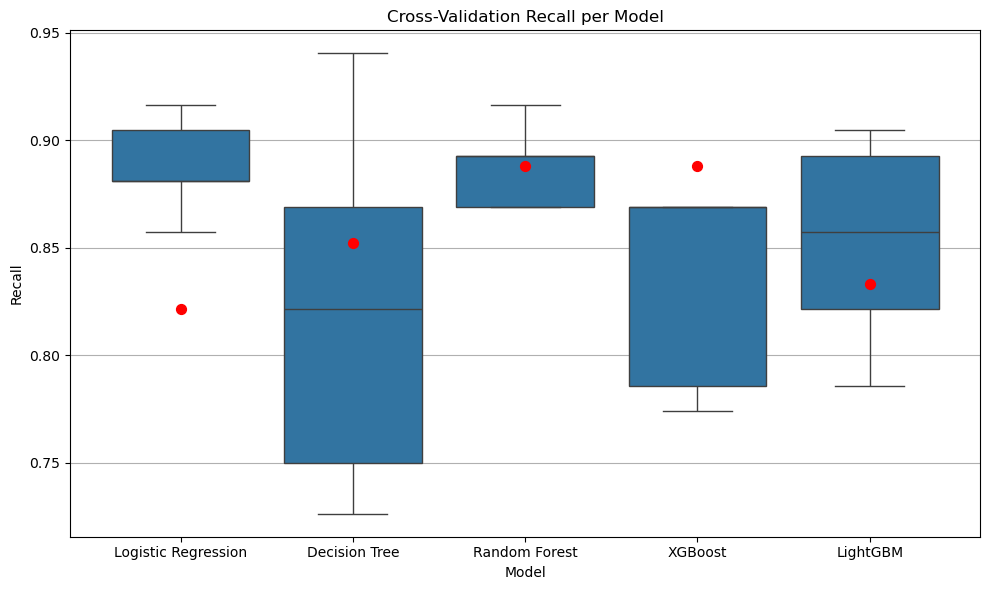

In [460]:
import seaborn as sns
import matplotlib.pyplot as plt

df_all_cv_data = pd.DataFrame(all_cv_data)
means = df_all_cv_data.groupby("model")["recall"].mean().reset_index()
medians = df_all_cv_data.groupby("model")["recall"].median().reset_index()

plt.figure(figsize=(10, 6))

sns.boxplot(data=df_all_cv_data, x='model', y='recall')
plt.scatter(x=range(len(means)), y=means["recall"], color='red', label='Mean', zorder=5, s=50)


plt.title('Cross-Validation Recall per Model')
plt.ylabel('Recall')
plt.xlabel('Model')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## Logistic Regression fine tune

Switched scoring metric to f2 socre. More tolerant to FP but put more weight to recall score. 

In [461]:
from sklearn.metrics import make_scorer, fbeta_score

In [462]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)

lr_param_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.5, 1, 1.5, 2, 5],
    'model__solver': ['liblinear', 'saga']
}

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('select', SelectKBest(score_func=f_classif, k=20)),
    ('model', lr_model)
])

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=lr_param_grid,
    scoring=make_scorer(fbeta_score, beta=2), 
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [463]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__C=0.5, model__penalty=l1, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.5, model__penalty=l1, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.5, model__penalty=l1, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.5, model__penalty=l1, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.5, model__penalty=l1, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.5, model__penalty=l1, model__solver=saga; total time=   0.1s
[CV] END model__C=0.5, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.5, model__penalty=l1, model__solver=saga; total time=   0.0s[CV] END model__C=0.5, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.5, model__penalty=l1, model__solver=saga; total time=   0.1s

[CV] END model__C=0.5, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] EN

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('ord',
                                                                         OrdinalEncoder(categories=[['no '
                                                                                                     'checking '
                                                                                                     'account',
                                                                                                     '< '
                                                                                                     '0 '
                                                                                                     'DM',
                                                                                                     '0 '
                                                                                                     '<= '
                                                                                                     '... '
                                                                                                     '< '
                                                                                                     '200 '
                                                                                                     'DM',
                                                                                                     '>= '
                                                                                                     '200 '
                                                                                                     'DM '
                                                                                                     '/ '
                                                                                                     'salary '
                                                                                                     'assignment'],
                                                                                                    ['unknown',
                                                                                                     '< '
                                                                                                     '100 '
                                                                                                     'DM',
                                                                                                     '100-500 '
                                                                                                     'DM',
                                                                                                     '500-1000 '
                                                                                                     'DM',
                                                                                                     '>= '
                                                                                                     '1000 '
                                                                                                     'DM'],
                                                                                                    ['u...
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['duration_mon',
                                                                          'credit_amount',
                                                                          'age'])])),
                                       ('select', SelectKBest(k=20)),
                               

In [464]:
print("Best Parameters:")
print(grid_search.best_params_)

from sklearn.metrics import precision_score, recall_score

y_pred_val = grid_search.best_estimator_.predict(X_val)
val_precision = precision_score(y_val, y_pred_val)
val_recall = recall_score(y_val, y_pred_val)

print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

Best Parameters:
{'model__C': 0.5, 'model__penalty': 'l1', 'model__solver': 'saga'}
Validation Precision: 0.7444
Validation Recall: 0.9571


In [465]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

[[ 14  46]
 [  6 134]]
              precision    recall  f1-score   support

           0       0.70      0.23      0.35        60
           1       0.74      0.96      0.84       140

    accuracy                           0.74       200
   macro avg       0.72      0.60      0.59       200
weighted avg       0.73      0.74      0.69       200



In [466]:
from sklearn.metrics import fbeta_score, accuracy_score, f1_score
val_fbeta = fbeta_score(y_val, y_pred_val, beta=2)
val_acc = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)

grid_row = {
    'model': 'Logistic + GridSearch (threshold=0.5)',
    'precision': round(val_precision, 4),
    'recall': round(val_recall, 4),
    'f1': round(val_f1, 4),  
    'f2': round(val_fbeta, 4),
    'accuracy': round(val_acc, 4)
}

df_results = pd.concat([df_results, pd.DataFrame([grid_row])], ignore_index=True)
df_results

,model,recall,accuracy,f1,f2,precision
0,Logistic Regression,0.8881 ± 0.0208,0.7033 ± 0.0135,0.8073 ± 0.0089,0.8539 ± 0.0143,0.7404 ± 0.0123
1,Decision Tree,0.8214 ± 0.0782,0.6967 ± 0.0292,0.7898 ± 0.0301,0.8077 ± 0.0571,0.7653 ± 0.0233
2,Random Forest,0.8881 ± 0.0178,0.7333 ± 0.0242,0.8235 ± 0.0149,0.8610 ± 0.0153,0.7679 ± 0.0191
3,XGBoost,0.8333 ± 0.0439,0.7267 ± 0.0255,0.8099 ± 0.0197,0.8235 ± 0.0326,0.7897 ± 0.0250
4,LightGBM,0.8524 ± 0.0443,0.7383 ± 0.0125,0.8197 ± 0.0142,0.8387 ± 0.0316,0.7913 ± 0.0150
5,Logistic + GridSearch (threshold=0.5),0.9571,0.74,0.8375,0.9054,0.7444


Exploring threshold: 

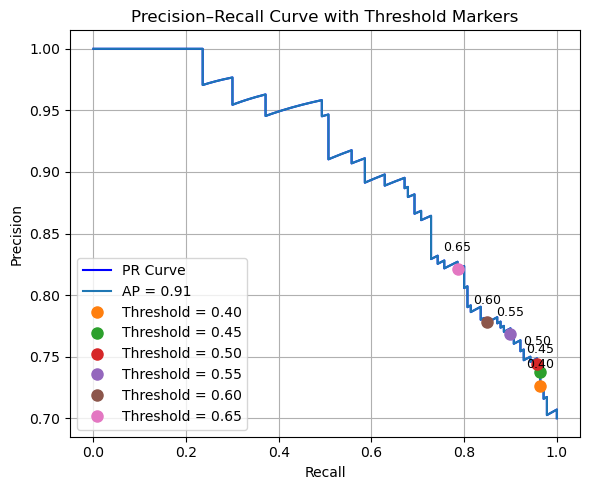

In [467]:
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score

y_scores = grid_search.best_estimator_.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
ap_score = average_precision_score(y_val, y_scores)

custom_thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
markers = []

# 计算并记录每个自定义阈值下的 precision 和 recall
for thresh in custom_thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    p = precision_score(y_val, y_pred_thresh)
    r = recall_score(y_val, y_pred_thresh)
    markers.append((r, p, thresh))  # recall, precision, threshold

# 清晰地只画 PR 曲线
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="PR Curve", color='blue')
plt.plot(recall, precision, label=f"AP = {ap_score:.2f}")

# 再逐点加 marker（无论它是不是 curve 上已有的点）
for r, p, t in markers:
    plt.plot(r, p, 'o', markersize=8, label=f"Threshold = {t:.2f}")
    plt.text(r, p + 0.015, f"{t:.2f}", fontsize=9, ha='center')

# 图例和标签
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve with Threshold Markers")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [468]:
from sklearn.metrics import precision_score, recall_score

for t in custom_thresholds:
    y_pred = (y_scores >= t).astype(int)
    p = precision_score(y_val, y_pred)
    r = recall_score(y_val, y_pred)
    f1 = fbeta_score(y_val, y_pred, beta=1)
    f2 = fbeta_score(y_val, y_pred, beta=2)
    print(f"Threshold = {t:.2f} | Precision = {p:.4f}, Recall = {r:.4f}, F1 = {f1:.4f}, F2 = {f2:.4f}")

Threshold = 0.40 | Precision = 0.7258, Recall = 0.9643, F1 = 0.8282, F2 = 0.9048
Threshold = 0.45 | Precision = 0.7377, Recall = 0.9643, F1 = 0.8359, F2 = 0.9085
Threshold = 0.50 | Precision = 0.7444, Recall = 0.9571, F1 = 0.8375, F2 = 0.9054
Threshold = 0.55 | Precision = 0.7683, Recall = 0.9000, F1 = 0.8289, F2 = 0.8702
Threshold = 0.60 | Precision = 0.7778, Recall = 0.8500, F1 = 0.8123, F2 = 0.8345
Threshold = 0.65 | Precision = 0.8209, Recall = 0.7857, F1 = 0.8029, F2 = 0.7925


In [469]:
threshold = 0.45
y_pred_045 = (y_scores >= threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_045))

print("\nClassification Report:")
print(classification_report(y_val, y_pred_045))


Confusion Matrix:
[[ 12  48]
 [  5 135]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.20      0.31        60
           1       0.74      0.96      0.84       140

    accuracy                           0.73       200
   macro avg       0.72      0.58      0.57       200
weighted avg       0.73      0.73      0.68       200



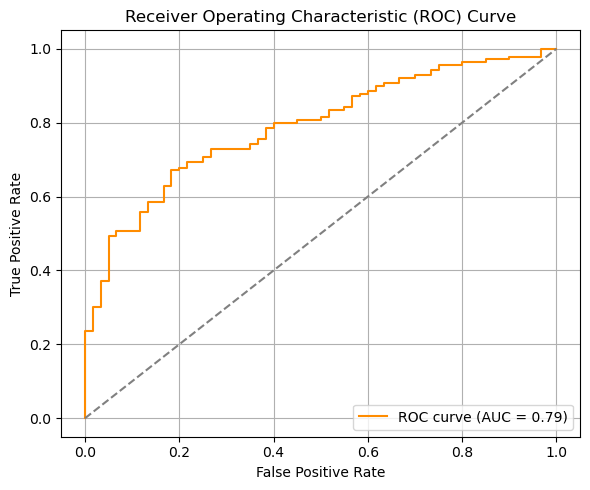

In [470]:
# ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

# 画图
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [471]:
# valuate on test set
y_test_scores = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_scores >= 0.45).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# 可选：你之前在 grid search 里用的是 beta=2
f_beta_test = fbeta_score(y_test, y_test_pred, beta=2)
print(f"\nF2-score on Test Set (threshold = 0.45): {f_beta_test:.4f}")

Confusion Matrix (Test Set):
[[ 15  45]
 [  9 131]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.62      0.25      0.36        60
           1       0.74      0.94      0.83       140

    accuracy                           0.73       200
   macro avg       0.68      0.59      0.59       200
weighted avg       0.71      0.73      0.69       200


F2-score on Test Set (threshold = 0.45): 0.8899


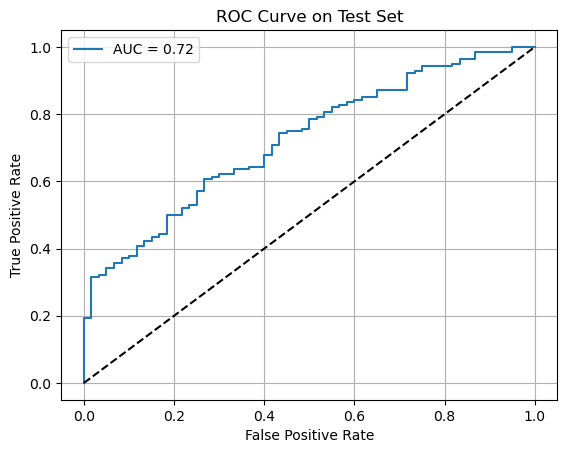

In [472]:
fpr, tpr, _ = roc_curve(y_test, y_test_scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve on Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [473]:
# tune threshold in cv

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

# 替换为你实际的特征和标签变量
X = X_train  # 或 X_processed
y = y_train  # 或 y_processed

# 阈值范围
threshold_values = np.arange(0.3, 0.51, 0.05)

# CV 设置
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
cv_results = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train_cv = X.iloc[train_idx]
    X_val_cv = X.iloc[val_idx]
    y_train_cv = y.iloc[train_idx]
    y_val_cv = y.iloc[val_idx]

    pipeline = Pipeline([
        ('preprocess', preprocessor),  # 使用你已有的预处理器
        ('select', SelectKBest(score_func=f_classif, k=10)),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=123))
    ])
    pipeline.fit(X_train_cv, y_train_cv)

    # 模型预测概率
    y_probs = pipeline.predict_proba(X_val_cv)[:, 1]

    best_fbeta = -1
    best_threshold = None
    best_prec, best_rec = 0, 0

    for t in threshold_values:
        y_pred = (y_probs >= t).astype(int)
        prec = precision_score(y_val_cv, y_pred)
        rec = recall_score(y_val_cv, y_pred)
        fbeta = fbeta_score(y_val_cv, y_pred, beta=2)

        if fbeta > best_fbeta:
            best_fbeta = fbeta
            best_threshold = t
            best_prec = prec
            best_rec = rec

    cv_results.append({
        "fold": fold + 1,
        "best_threshold": best_threshold,
        "precision": best_prec,
        "recall": best_rec,
        "fbeta": best_fbeta
    })

cv_df = pd.DataFrame(cv_results)
display(cv_df)

,fold,best_threshold,precision,recall,fbeta
0,1,0.30,0.692308,0.857143,0.818182
1,2,0.30,0.723404,0.809524,0.790698
2,3,0.30,0.795918,0.928571,0.898618
3,4,0.35,0.711538,0.880952,0.840909
4,5,0.30,0.685185,0.880952,0.833333
5,6,0.30,0.722222,0.928571,0.878378
6,7,0.30,0.705882,0.857143,0.821918
7,8,0.30,0.780000,0.928571,0.894495
8,9,0.30,0.740000,0.880952,0.848624
9,10,0.30,0.734694,0.857143,0.829493


In [474]:
from sklearn.metrics import accuracy_score, f1_score
# 1. 找出现频率最高的 threshold
most_common_threshold = cv_df['best_threshold'].mode()[0]
print(f"Most frequent best_threshold across folds: {most_common_threshold:.2f}")

# 2. 用这个 threshold 在每一折上重新评估 precision, recall, fbeta
# （重新跑的原因是：之前的 precision/recall 是每折自己的 best_threshold 下的）
cv_metrics_fixed_threshold = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
    
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('select', SelectKBest(score_func=f_classif, k=20)),
        ('model', LogisticRegression(max_iter=1000, random_state=123))
    ])
    
    pipeline.fit(X_train_cv, y_train_cv)
    y_probs = pipeline.predict_proba(X_val_cv)[:, 1]
    y_pred = (y_probs >= most_common_threshold).astype(int)
    
    prec = precision_score(y_val_cv, y_pred)
    rec = recall_score(y_val_cv, y_pred)
    fbeta = fbeta_score(y_val_cv, y_pred, beta=2)
    acc = accuracy_score(y_val_cv, y_pred)
    f1 = f1_score(y_val_cv, y_pred)

    
    cv_metrics_fixed_threshold.append({
        'fold': fold + 1,
        'precision': prec,
        'recall': rec,
        'f2': fbeta, 
        "accuracy": acc,
        "f1": f1
    })

# 3. 构建 DataFrame 并输出平均性能
df_cv_fixed = pd.DataFrame(cv_metrics_fixed_threshold)
avg_results = df_cv_fixed.mean(numeric_only=True).to_dict()

print("\n📊 Average Metrics with Threshold = {:.2f}".format(most_common_threshold))
print("Precision: {:.4f}".format(avg_results['precision']))
print("Recall: {:.4f}".format(avg_results['recall']))
print("F2-score: {:.4f}".format(avg_results['f2']))

# 如需展示详细表格
display(df_cv_fixed)

Most frequent best_threshold across folds: 0.30

📊 Average Metrics with Threshold = 0.30
Precision: 0.7116
Recall: 0.9738
F2-score: 0.9069


,fold,precision,recall,f2,accuracy,f1
0,1,0.711864,1.000000,0.925110,0.716667,0.831683
1,2,0.714286,0.952381,0.892857,0.700000,0.816327
2,3,0.706897,0.976190,0.907080,0.700000,0.820000
3,4,0.706897,0.976190,0.907080,0.700000,0.820000
4,5,0.689655,0.952381,0.884956,0.666667,0.800000
5,6,0.706897,0.976190,0.907080,0.700000,0.820000
6,7,0.694915,0.976190,0.903084,0.683333,0.811881
7,8,0.732143,0.976190,0.915179,0.733333,0.836735
8,9,0.745455,0.976190,0.919283,0.750000,0.845361
9,10,0.706897,0.976190,0.907080,0.700000,0.820000


In [475]:
# Step 1: 取平均值
avg_results = df_cv_fixed.mean(numeric_only=True)
std_results = df_cv_fixed.std(numeric_only=True)


# Step 2: 构造一行新的比较记录
new_row = {
    'model': 'Logistic + tuned threshold ({:.2f})'.format(most_common_threshold),
    'precision': f"{avg_results['precision']:.4f} ± {std_results['precision']:.4f}",
    'recall':    f"{avg_results['recall']:.4f} ± {std_results['recall']:.4f}",
    'f2':      f"{avg_results['f2']:.4f} ± {std_results['f2']:.4f}",
    'accuracy':  f"{avg_results['accuracy']:.4f} ± {std_results['accuracy']:.4f}",
    'f1':        f"{avg_results['f1']:.4f} ± {std_results['f1']:.4f}"
}

# Step 3: 追加进结果表格
df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)

# Step 4: 查看
display(df_results)

,model,recall,accuracy,f1,f2,precision
0,Logistic Regression,0.8881 ± 0.0208,0.7033 ± 0.0135,0.8073 ± 0.0089,0.8539 ± 0.0143,0.7404 ± 0.0123
1,Decision Tree,0.8214 ± 0.0782,0.6967 ± 0.0292,0.7898 ± 0.0301,0.8077 ± 0.0571,0.7653 ± 0.0233
2,Random Forest,0.8881 ± 0.0178,0.7333 ± 0.0242,0.8235 ± 0.0149,0.8610 ± 0.0153,0.7679 ± 0.0191
3,XGBoost,0.8333 ± 0.0439,0.7267 ± 0.0255,0.8099 ± 0.0197,0.8235 ± 0.0326,0.7897 ± 0.0250
4,LightGBM,0.8524 ± 0.0443,0.7383 ± 0.0125,0.8197 ± 0.0142,0.8387 ± 0.0316,0.7913 ± 0.0150
5,Logistic + GridSearch (threshold=0.5),0.9571,0.74,0.8375,0.9054,0.7444
6,Logistic + tuned threshold (0.30),0.9738 ± 0.0135,0.7050 ± 0.0236,0.8222 ± 0.0129,0.9069 ± 0.0118,0.7116 ± 0.0164
